#Demo for HAR load_dataset functions
load_dataset_demo.ipynb

This is a brief demo and simple test of the load_dataset functions that convert the raw time based accelerometer data and human activity recognition (HAR) labels to trainX, trainy, testX, testy numpy arrays. 
* Builds numpy arrays using load_dataset functions and default arguments
* Builds/Trains/Evaluates a 1D CNN classifier for the selected dataset
* Displays several model evaluation figures and metrics

Comments:  MobiAct and UniMiB SHAR accuracies exceed 90% using total acceleration, UCI HAR and e4_Nov2019 have difficulty with standing/laying/sitting so component acceleration is included which increases overall accruacies.   This may not generalize well if the training set does not include a case where the device orientation is similar to the test case.  i.e. using component accel introduces orientation "awareness" and may hurt generalization.
The e4 data set is very small making it easy to experiment with but the loss curves will not be nearly as uniform and it is easy to overfit the data. 

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2021

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* DONE - Fix Keras Input layer warning.



In [1]:
#mount google drive in colab session
#enter path to where the git repo was cloned
my_path = '/content/drive/My Drive/Colab Notebooks/public_repositories/load_data_time_series'

# Get environment info if colab plus a few helper functions

In [2]:
if 'google.colab' in str(get_ipython()):
    cpu_model = !grep 'model name' /proc/cpuinfo
    header = 'CPU1: ' + cpu_model[0] + '\n'
    header += 'CPU2: ' + cpu_model[1] + '\n'
    gpu_info = !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
    header += 'GPU: ' + str(gpu_info[1]) + '\n'
else:
    header = 'Locally executed'
print(header)

CPU1: model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
CPU2: model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
GPU: Tesla P100-PCIE-16GB, 460.32.03, 16280 MiB



In [3]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

#Imports

In [4]:
import os
import shutil
from scipy import io #for loadmat, matlab conversion
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

In [5]:
#@title Select Dataset
dataset = "MobiAct ADL" #@param ["MobiAct ADL", "UniMiB SHAR","UCI HAR","e4_Nov2019","Leotta_2021"]


In [6]:
print("Using",dataset,"dataset")
if (dataset == 'Leotta_2021'):
    print ("NOTE: this dataset requires a high-RAM runtime on colab")

Using MobiAct ADL dataset


#Get numpy arrays from load_dataset

In [7]:
# Copy selected .py file into colab and import load_dataset function
# k_size is the size of the kernel used in the model, one-half of a second
# works well, actual value is based on sample freq e.g. 32Hz -> k_size = 16.
if (dataset == 'MobiAct ADL'):
    full_filename = my_path+os.path.join('/HAR/MobiAct/'+'mobiact_adl_load_dataset.py')
    shutil.copy(full_filename,'mobiact_adl_load_dataset.py')
    from mobiact_adl_load_dataset import mobiact_adl_load_dataset
    #x_train, y_train, x_test, y_test = mobiact_adl_load_dataset(incl_val_group = False)
    x_train, y_train, x_validate, y_validate, x_test, y_test = mobiact_adl_load_dataset(incl_val_group = True)
    k_size = 50
    EPOCHS = 50
    t_names = ['JOG','JUM','STD','STN','STU','WAL']
elif (dataset == 'UniMiB SHAR'):
    full_filename = my_path+ os.path.join('/HAR/UniMiB_SHAR/'+'unimib_shar_adl_load_dataset.py')
    shutil.copy(full_filename,'unimib_shar_adl_load_dataset.py')
    from unimib_shar_adl_load_dataset import unimib_load_dataset
    #x_train, y_train, x_test, y_test = unimib_load_dataset(incl_val_group = False)
    x_train, y_train, x_validate, y_validate, x_test, y_test = unimib_load_dataset(incl_val_group = True)
    t_names = ['StandingUpFS','StandingUpFL','Walking','Running','GoingUpS','Jumping','GoingDownS','LyingDownFS','SittingDown']
    k_size = 50
    EPOCHS = 60
elif (dataset == 'UCI HAR'):
    full_filename = my_path+os.path.join('/HAR/UCI_HAR/'+'uci_har_load_dataset.py')
    shutil.copy(full_filename,'uci_har_load_dataset.py')
    from uci_har_load_dataset import uci_har_load_dataset
    #x_train, y_train, x_test, y_test = uci_har_load_dataset(incl_val_group = False)
    x_train, y_train, x_validate, y_validate, x_test, y_test = uci_har_load_dataset(incl_val_group = True, incl_xyz_accel= True)
    t_names = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
    k_size = 50
    EPOCHS = 120
elif (dataset == 'e4_Nov2019'):
    full_filename = my_path+os.path.join('/HAR/e4_wristband_Nov2019/'+'e4_load_dataset.py')
    shutil.copy(full_filename,'e4_load_dataset.py')
    from e4_load_dataset import e4_load_dataset
    x_train, y_train, x_validate, y_validate, x_test, y_test = e4_load_dataset(incl_val_group = True, incl_xyz_accel= True)
    t_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
    k_size = 16
    EPOCHS = 30 # with the small training set 100 epochs overfits badly
elif (dataset == 'Leotta_2021'):
    full_filename = my_path+os.path.join('/ADL/Leotta_2021/'+'leotta_2021_load_dataset.py')
    shutil.copy(full_filename,'leotta_2021_load_dataset.py')
    from leotta_2021_load_dataset import leotta_2021_load_dataset
    x_train, y_train, x_validate, y_validate, x_test, y_test = leotta_2021_load_dataset(incl_val_group = True)
    # Note:  OTHER referenced in readme.txt was deleted during the processing,
    # and the one-hot encoding shifted everything by one, hence RELAX = 0 now
    t_names = ['RELAX','KEYBOARD_WRITING','LAPTOP','HANDWRITING',
                'HANDWASHING','FACEWASHING','TEETHBRUSH','SWEEPING','VACUUMING',
                'EATING','DUSTING','RUBBING','DOWNSTAIRS','WALKING',
                'WALKING_FAST','UPSTAIRS_FAST','UPSTAIRS']
    k_size = 100
    EPOCHS = 50   
else:
    print('ERROR: dataset unknown')

print(get_shapes([x_train, y_train, x_validate, y_validate, x_test, y_test]))

Unzipping MobiAct Dataset
Generating filenames  JOG_acc_*.txt  from  /content/MobiAct_Dataset/JOG/  directory
Generating filenames  JUM_acc_*.txt  from  /content/MobiAct_Dataset/JUM/  directory
Generating filenames  STD_acc_*.txt  from  /content/MobiAct_Dataset/STD/  directory
Generating filenames  STN_acc_*.txt  from  /content/MobiAct_Dataset/STN/  directory
Generating filenames  STU_acc_*.txt  from  /content/MobiAct_Dataset/STU/  directory
Generating filenames  WAL_acc_*.txt  from  /content/MobiAct_Dataset/WAL/  directory
x_train shape is (4190, 500, 1) data type is float64
y_train shape is (4190, 6) data type is float64
x_validate shape is (1397, 500, 1) data type is float64
y_validate shape is (1397, 6) data type is float64
x_test shape is (1395, 500, 1) data type is float64
y_test shape is (1395, 6) data type is float64



#Build a 1D CNN model
topology and good article
[here](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf)

In [8]:
#topology and good article here
#https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
if (True):
	n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
	model = keras.Sequential(
		[
			#keras.Input(shape=(n_timesteps,n_features)),
			layers.Conv1D(filters=100, kernel_size=k_size, activation='relu',input_shape=(n_timesteps,n_features)),
			layers.Conv1D(filters=100, kernel_size=k_size, activation='relu'),
			layers.Dropout(0.5),
			layers.MaxPooling1D(pool_size=2),
			layers.Flatten(),
			layers.Dense(100, activation='relu'),
			layers.Dense(n_outputs, activation='softmax')
   		]
	)
	model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 451, 100)          5100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 402, 100)          500100    
_________________________________________________________________
dropout (Dropout)            (None, 402, 100)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 201, 100)          0         
_________________________________________________________________
flatten (Flatten)            (None, 20100)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2010100   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6

#Train the model

In [9]:
BATCH_SIZE = 32     # Typical values are 8, 16 or 32
NUM_EPOCHS = EPOCHS

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(
        x_train,y_train,
        steps_per_epoch=x_train.shape[1]//BATCH_SIZE,
        epochs=NUM_EPOCHS,
        validation_data=(x_validate,y_validate),
        validation_steps=x_validate.shape[1]//BATCH_SIZE)

Epoch 1/50
15/15 [==============================] - 3s 87ms/step - loss: 2.4558 - accuracy: 0.3430 - val_loss: 1.1394 - val_accuracy: 0.7516
Epoch 2/50
15/15 [==============================] - 1s 49ms/step - loss: 0.9330 - accuracy: 0.8110 - val_loss: 0.8184 - val_accuracy: 0.9062
Epoch 3/50
15/15 [==============================] - 1s 50ms/step - loss: 0.7127 - accuracy: 0.8857 - val_loss: 0.6782 - val_accuracy: 0.9298
Epoch 4/50
15/15 [==============================] - 1s 49ms/step - loss: 0.6565 - accuracy: 0.9146 - val_loss: 0.6579 - val_accuracy: 0.9520
Epoch 5/50
15/15 [==============================] - 1s 50ms/step - loss: 0.5471 - accuracy: 0.9544 - val_loss: 0.5382 - val_accuracy: 0.9792
Epoch 6/50
15/15 [==============================] - 1s 50ms/step - loss: 0.4671 - accuracy: 0.9726 - val_loss: 0.4790 - val_accuracy: 0.9792
Epoch 7/50
15/15 [==============================] - 1s 50ms/step - loss: 0.4084 - accuracy: 0.9835 - val_loss: 0.4285 - val_accuracy: 0.9785
Epoch 8/50
15

#Show Final Validation Accuracy and Loss Curve 

MobiAct ADL 1D CNN
Final Validation Accuracy: 0.977


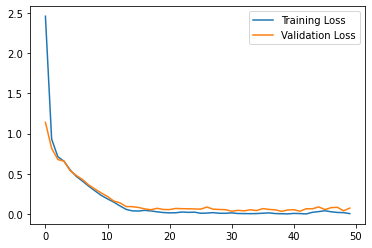

In [10]:
print(dataset, "1D CNN")
print("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
#plt.ylim([0,1.2]) #set limit - 1.2 has been a good value experimentally
plt.legend()
plt.show()

# Run the model - predict using the test data

Prediction accuracy: 0.951
              precision    recall  f1-score   support

         JOG       1.00      0.88      0.93       147
         JUM       0.91      0.97      0.94       145
         STD       0.99      1.00      1.00       425
         STN       0.80      0.73      0.77        60
         STU       0.66      0.87      0.75        60
         WAL       0.97      0.96      0.97       558

    accuracy                           0.95      1395
   macro avg       0.89      0.90      0.89      1395
weighted avg       0.95      0.95      0.95      1395



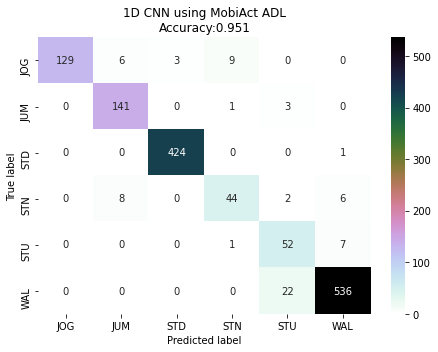

In [11]:
predictions = model.predict(x_test, verbose=0,batch_size=32)
#must use values not one-hot encoding, use argmax to convert
y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding
print('Prediction accuracy: {0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
#return (accuracy_score(y_temp, y_pred)),y_pred
y_test_act = np.argmax(y_test, axis=-1) #undo one-hot encoding
print(classification_report(y_test_act, y_pred, target_names=t_names))
cm = confusion_matrix(y_test_act, y_pred)
cm_df = pd.DataFrame(cm,
                     index = t_names, 
                     columns = t_names)
fig = plt.figure(figsize=(6.5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('1D CNN using '+dataset+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()